In [25]:
import math

import pandas as pd

In [26]:
MAX_STEER = 100.0
MAX_LF_STEER = 1.0 # max fraction of MAX_STEER that it will do while line following

N = 100  # number of data points in normalized datasets (200 for real data?)

R_R_R = 2  # calibrated "red" values for right sensor
G_R_R = 5
B_R_R = 3

R_R_L = 2  # calibrated "red" values for left sensor
G_R_L = 5
B_R_L = 3

In [27]:
def weighted_diff(weights, r_l, g_l, b_l, r_r, g_r, b_r):
    L_notred = abs(
        (weights[1] * (r_l - R_R_L)) + (weights[2] * (g_l - G_R_L)) + (weights[3] * (b_l - B_R_L))
    )
    R_notred = abs(
        (weights[4] * (r_r - R_R_R)) + (weights[5] * (g_r - G_R_R)) + (weights[6] * (b_r - B_R_R))
    )
    diff = L_notred - R_notred
    steer = ((MAX_STEER * MAX_LF_STEER) / weights[0]) * diff
    return steer

def weighted_diff_steers(weights, l_df, r_df):
    steer = []
    for i in range(N):
        steer.append(
            weighted_diff(
                weights,
                l_df.loc[i, "R"],
                l_df.loc[i, "G"],
                l_df.loc[i, "B"],
                r_df.loc[i, "R"],
                r_df.loc[i, "G"],
                r_df.loc[i, "B"],
            )
        )
    return steer

In [28]:
def ideal_linear():
    linear = []
    for i in range(0, math.ceil(N / 2)):
        linear.append(
            (MAX_STEER * MAX_LF_STEER) * (math.floor(N / 2) - i) / math.floor(N / 2)
        )
    for i in range(math.ceil(N / 2), N):
        linear.append(
            -1 * (MAX_STEER * MAX_LF_STEER) * (i - math.floor(N / 2)) / math.floor(N / 2)
        )
    return linear

In [29]:
class Normalized():
    l_df_norm = pd.DataFrame()
    r_df_norm = pd.DataFrame()

    def __init__(self, l, r):
        self.l_df_norm = l
        self.r_df_norm = r

def normalize_data(l_df, r_df):
    # return lists of data representing the inputted lists stretched/compressed to fit to N
    # approximate linear interpolations by taking nearest value
    l_r_norm = [0 for i in range(N)]
    l_g_norm = [0 for i in range(N)]
    l_b_norm = [0 for i in range(N)]
    r_r_norm = [0 for i in range(N)]
    r_g_norm = [0 for i in range(N)]
    r_b_norm = [0 for i in range(N)]

    for i in range(N):
        l_r_norm[i] = l_df.loc[round((len(l_df)/N)*i), "R"]
        l_g_norm[i] = l_df.loc[round((len(l_df)/N)*i), "G"]
        l_b_norm[i] = l_df.loc[round((len(l_df)/N)*i), "B"]
        r_r_norm[i] = r_df.loc[round((len(r_df)/N)*i), "R"]
        r_g_norm[i] = r_df.loc[round((len(r_df)/N)*i), "G"]
        r_b_norm[i] = r_df.loc[round((len(r_df)/N)*i), "B"]

    l_df_norm = pd.DataFrame({"R": l_r_norm, "G": l_g_norm, "B": l_b_norm})
    r_df_norm = pd.DataFrame({"R": r_r_norm, "G": r_g_norm, "B": r_b_norm})
    return Normalized(l_df_norm, r_df_norm)

In [30]:
def linear_R2(steer_vals, linear):
    total_e = 0.0
    for i in range(N):
        total_e += abs(steer_vals[i] - linear[i])
    return total_e / N

In [31]:
TRAIN_STEP_DIFF = 100
TRAIN_STEP_WEIGHT = 1

def calc_gradient(weights, l_df, r_df, steer_vals, linear):
    weights_copy = weights.copy()
    gradient = [0.0 for i in range(len(weights))]
    for i in range(len(weights_copy)):
        if i == 0:
            e_before = linear_R2(steer_vals, linear)
            weights_copy[i] += TRAIN_STEP_DIFF
            e_after = linear_R2(weighted_diff_steers(weights_copy, l_df, r_df), linear)
            weights_copy[i] -= TRAIN_STEP_DIFF
            if e_after < e_before:
                gradient[i] = TRAIN_STEP_DIFF# * (e_before / e_after)

            e_before = linear_R2(steer_vals, linear)
            weights_copy[i] -= TRAIN_STEP_DIFF
            e_after = linear_R2(weighted_diff_steers(weights_copy, l_df, r_df), linear)
            weights_copy[i] += TRAIN_STEP_DIFF
            if e_after < e_before:
                gradient[i] = -1 * TRAIN_STEP_DIFF# * (e_before / e_after)
        else:
            e_before = linear_R2(steer_vals, linear)
            weights_copy[i] += TRAIN_STEP_WEIGHT
            e_after = linear_R2(weighted_diff_steers(weights_copy, l_df, r_df), linear)
            weights_copy[i] -= TRAIN_STEP_WEIGHT
            if e_after < e_before:
                gradient[i] = TRAIN_STEP_WEIGHT# * (e_before / e_after)

            e_before = linear_R2(steer_vals, linear)
            weights_copy[i] -= TRAIN_STEP_WEIGHT
            e_after = linear_R2(weighted_diff_steers(weights_copy, l_df, r_df), linear)
            weights_copy[i] += TRAIN_STEP_WEIGHT
            if e_after < e_before:
                gradient[i] = -1 * TRAIN_STEP_WEIGHT# * (e_before / e_after)

    return gradient

Weights before training: [2500.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Error before training: 29.35719999999999
Weights after training: [2400.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0]
Error after training: 103.29499999999999


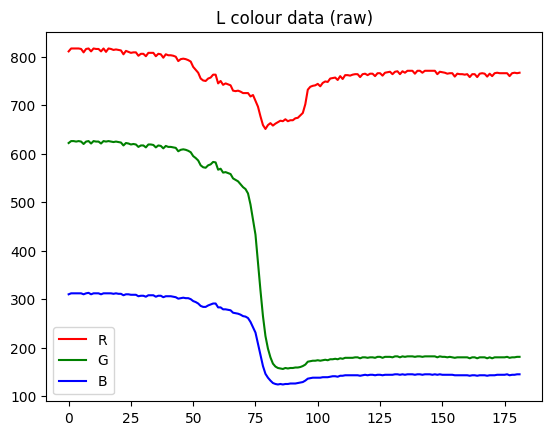

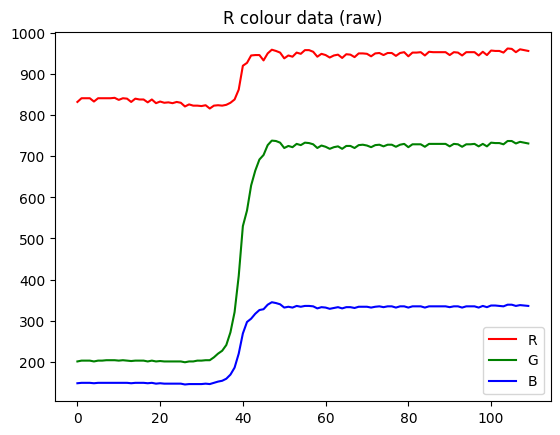

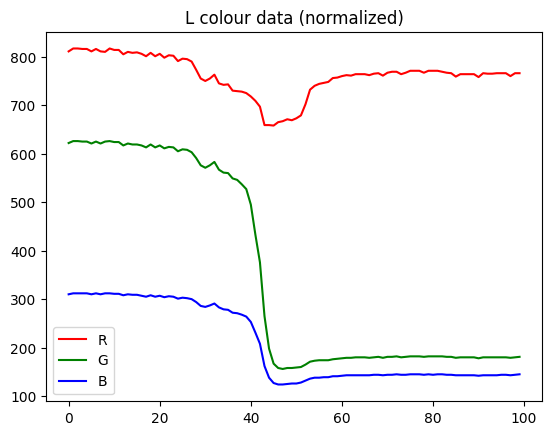

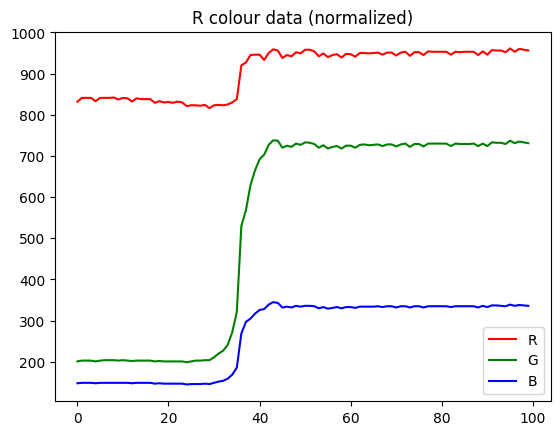

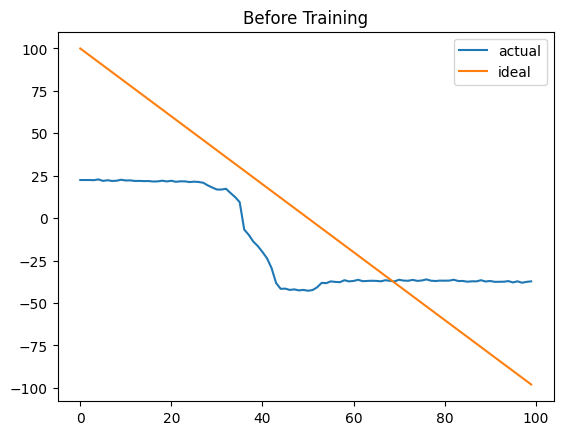

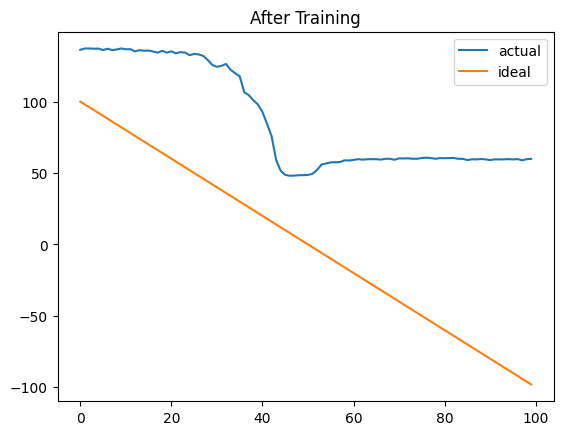

In [32]:
def train():
    my_colors = ["r", "g", "b"]

    # collect datasets by printing rgb readings of L and R sensor as robot is slid L to R
    # start with R sensor fully on red tape, stop when L sensor is fully on red tape
    # start is the case with max R steer, middle is no steer, end is max L steer
    l_df = pd.read_csv("L_data_sweep.csv")
    r_df = pd.read_csv("R_data_sweep.csv")
    l_df.plot(title="L colour data (raw)", color=my_colors)
    r_df.plot(title="R colour data (raw)", color=my_colors)

    normal = normalize_data(l_df, r_df)
    l_df_norm = normal.l_df_norm
    r_df_norm = normal.r_df_norm
    l_df_norm.plot(title="L colour data (normalized)", color=my_colors)
    r_df_norm.plot(title="R colour data (normalized)", color=my_colors)

    # weights: [max_diff, r_w_l, g_w_l, b_w_l, r_w_r, g_w_r, b_w_r]
    # initial values are here, to be tweaked during training
    weights = [2500.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
    print(f"Weights before training: {weights}")

    steer_vals = weighted_diff_steers(weights, l_df_norm, r_df_norm)
    linear = ideal_linear()
    error = linear_R2(weighted_diff_steers(weights, l_df, r_df), linear)
    print(f"Error before training: {error}")
    plot_df = pd.DataFrame({"actual": steer_vals, "ideal": linear})
    plot_df.plot(title="Before Training")

    TRAIN_ITERATIONS = 100
    for i in range(TRAIN_ITERATIONS):
        gradient = calc_gradient(weights, l_df_norm, r_df_norm, steer_vals, linear)
        for i in range(len(weights)):
            weights[i] += gradient[i]

    print(f"Weights after training: {weights}")
    error = linear_R2(weighted_diff_steers(weights, l_df, r_df), linear)
    print(f"Error after training: {error}")
    steer_vals_trained = weighted_diff_steers(weights, l_df_norm, r_df_norm)
    plot_df = pd.DataFrame({"actual": steer_vals_trained, "ideal": linear})
    plot_df.plot(title="After Training")


train()